In [1]:
import os
import pandas as pd
from PIL import Image
from datetime import datetime

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, labels_map, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_labels['label'] = self.img_labels['label'].map(labels_map)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        
        label = torch.tensor(int(self.img_labels.iloc[idx, 1]), dtype=torch.uint8)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Linear(in_features=512, out_features=num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resnet18(x)

In [4]:
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        
    else:
        pass

In [5]:
def dump_model(training_id, model_dir, model):
    model_name = f"{training_id}_resnet18_od.pth"
    create_dir(dir_name=model_dir)
        
    model_dump_fp = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_dump_fp)

In [6]:
labels_map = {
    'cassette_player': 0,
    'chain_saw': 1,
    'church': 2,
    'english_springer': 3,
    'french_horn': 4,
    'garbage_truck': 5,
    'gas_pump': 6,
    'golf_ball': 7,
    'parachute': 8,
    'tench': 9
}

In [7]:
train_annotation_fp = "train.csv"
test_annotation_fp = "test.csv"

model_dir = "./models"
training_id = f"baseline_{datetime.utcnow().timestamp()}"

log_dir = os.path.join("./log_dir", training_id)
create_dir(log_dir)

In [8]:
# ResNet-18 expects input images of size (224, 224)
feature_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(annotations_file=train_annotation_fp, 
                                   labels_map=labels_map,
                                   transform=feature_transform,
                                  )
test_dataset = CustomImageDataset(annotations_file=test_annotation_fp, 
                                  labels_map=labels_map,
                                  transform=feature_transform,
                                 )

# Define the DataLoader
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])


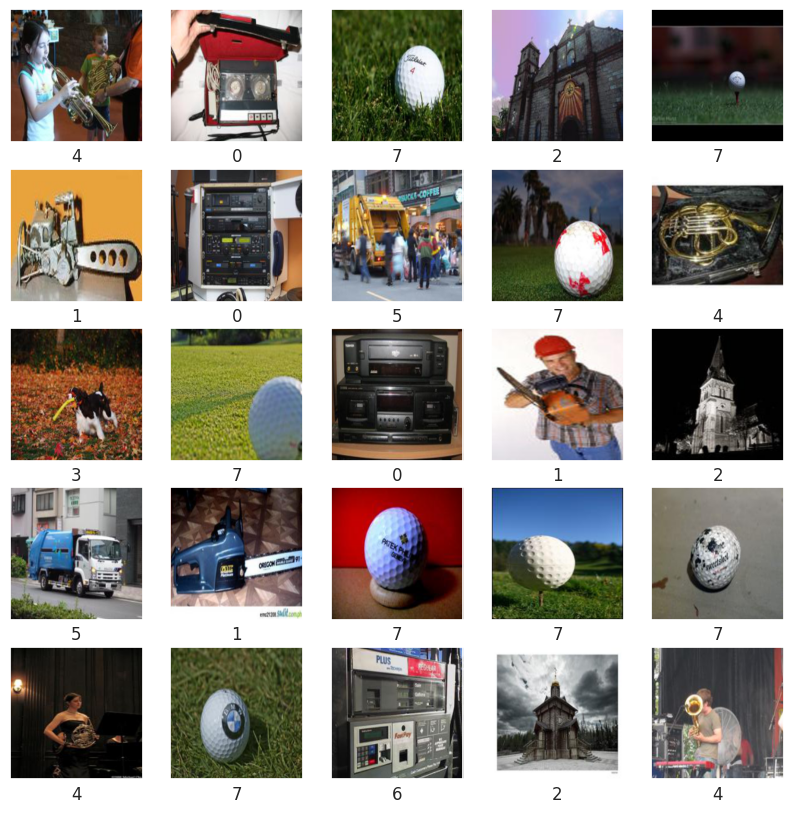

In [10]:
# Plotting some image samples from the dataloaders
plt.figure(figsize=(10,10))
for i in range(25):
    train_features, train_labels = next(iter(train_dataloader))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_features[0].numpy().transpose((1, 2, 0)))
    plt.xlabel(train_labels[0].tolist())
plt.show()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_class = 10
learning_rate = 1e-03
num_epoch = 2
save_model = True

model = ResNetModel(num_classes=num_class)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/home/sasmi/anaconda3/envs/jarvis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sasmi/anaconda3/envs/jarvis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
model.train()
model.to(device)

epoch_ls, total_loss, total_accuracy = [], [], []

for epoch in range(num_epoch):

    loss_train, acc_train = 0, 0
    total_samples = 0
    
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # calculate the loss and accuracy
        loss_train += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        acc_train += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = loss_train / len(train_dataloader)
    epoch_accuracy = acc_train / total_samples
    
    epoch_ls.append(epoch)
    total_loss.append(epoch_loss)
    total_accuracy.append(epoch_accuracy)
    
    print(f"Current epoch: {epoch} | Training Accuracy: {epoch_accuracy} | Training Loss: {epoch_loss}")
    
if save_model:
    dump_model(training_id, model_dir, model)

Current epoch: 0 | Training Accuracy: 0.24897388059701492 | Training Loss: 2.10973241653905
Current epoch: 1 | Training Accuracy: 0.39561567164179107 | Training Loss: 1.7405967928913992


In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
test_acc = 100 * correct // total
print(f'Test Accuracy: {test_acc}%')

Test Accuracy: 46%


In [14]:
train_metrics_df = pd.DataFrame(zip(epoch_ls, total_loss, total_accuracy), columns=["epoch", "loss", "accuracy"])
train_metrics_df.to_csv(f"{os.path.join(log_dir, 'training_metrics.csv')}", index=False)
train_metrics_df

,epoch,loss,accuracy
0,0,2.109732,0.248974
1,1,1.740597,0.395616


In [15]:
test_acc = 100 * correct // total

In [16]:
test_metrics_df = pd.DataFrame([test_acc], columns=["accuracy"])
test_metrics_df.to_csv(f"{os.path.join(log_dir, 'test_metrics.csv')}", index=False)
test_metrics_df

,accuracy
0,46


<Axes: xlabel='epoch', ylabel='value'>

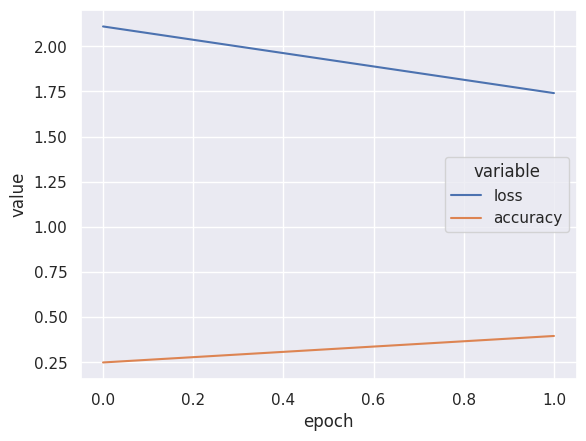

In [20]:
sns.lineplot(data=pd.melt(train_metrics_df, ["epoch"]), x="epoch", y="value", hue="variable")

### Deprecated Codes

In [17]:
# img = train_features[0].numpy().transpose((1, 2, 0))
# label = train_labels[0]
# plt.imshow(img)
# plt.show()
# print(f"Label: {label}")